In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import classification_report, log_loss
from sklearn.metrics import confusion_matrix

import random

random.seed(12345)

pd.options.display.max_columns = 100

In [66]:
path = './'
name = ''
out_name = path + name + 'submission_py.csv'

In [67]:

import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          doprint=True,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    if doprint:
        print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    if doprint:
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [68]:
# read data

train_data = pd.read_csv(path + name + 'train.csv')
test_data = pd.read_csv(path + name + 'test.csv')


In [69]:
print(train_data.shape)
print(test_data.shape)

(28746, 213)
(271251, 211)


In [70]:
# get first 5 seconds
qq = list(range(1,71))
X = train_data.iloc[:,qq].as_matrix()
Xt = test_data.iloc[:,qq].as_matrix()
y = train_data.iloc[:,-1].as_matrix()

print(X.shape)
print(Xt.shape)
print(y.shape)

(28746, 70)
(271251, 70)
(28746,)


# Test XGBoost on first 5 seconds

In [71]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05)
print(X_train.shape)
print(X_val.shape)


(27308, 70)
(1438, 70)


In [72]:
%%time
from xgboost import XGBClassifier
gbc = XGBClassifier(objective='multi:softprob',
                    learning_rate=0.2,
                    subsample=0.7,
                    colsample_bytree=0.9,
                    colsample_bylevel=0.7,
                    max_depth=5,
                    nthread=4,
                    n_estimators=50,
                    seed=1234)

gbc.fit(X_train,y_train)
pred = gbc.predict(X_val)
print(classification_report(y_pred=pred,y_true=y_val))
pred_proba = gbc.predict_proba(X_val)
print('log_loss: {}'.format(log_loss(y_pred=pred_proba,y_true=y_val)))

             precision    recall  f1-score   support

          1       0.89      0.79      0.84        91
          2       0.78      0.89      0.83        74
          3       0.31      0.59      0.41        82
          4       0.43      0.39      0.41        59
          5       0.38      0.30      0.33        88
          6       0.32      0.17      0.22        75
          7       0.23      0.40      0.29        73
          8       0.34      0.41      0.37        88
          9       0.23      0.14      0.18        77
         10       0.32      0.28      0.30        54
         11       0.41      0.15      0.22        46
         12       0.30      0.16      0.21        43
         13       0.42      0.70      0.52        61
         14       0.29      0.44      0.35        54
         15       0.23      0.16      0.19        50
         16       0.11      0.05      0.07        38
         17       0.33      0.33      0.33        42
         18       0.16      0.13      0.14   

Normalized confusion matrix


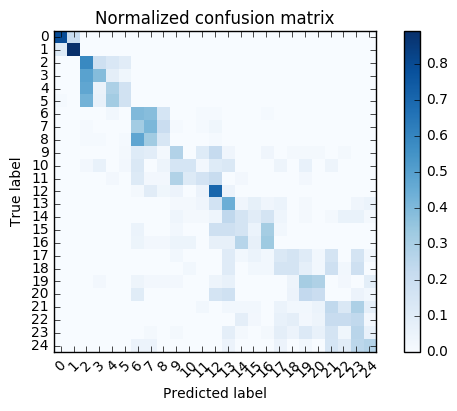

In [73]:
cnf_matrix = confusion_matrix(y_val, pred)
plt.figure()
classes = range(0,25)
plot_confusion_matrix(cnf_matrix, classes, normalize=True, doprint=False, title='Normalized confusion matrix')

In [74]:
#submit result

pred = gbc.predict(Xt)
pred = pred.astype(int)
df = pd.DataFrame(pred)
df.to_csv(out_name, header=False)

In [1]:
#compress result file
import gzip

in_data = open(out_name, "rb").read()
out_gz = out_name+".gz"
gzf = gzip.open(out_gz, "wb")
gzf.write(in_data)
gzf.close()